In [23]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn import datasets
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from yellowbrick.target import FeatureCorrelation
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
from datetime import datetime
import numpy as np
import lightgbm as lgb
import scipy
from scipy import stats

In [26]:
df_1 = pd.read_csv(".\\audiobooks.csv")
df_2 = pd.read_csv(".\\audiobooks_2.csv")
df = df_1.merge(df_2, on='audiobook_id')
df = df[['price', 'release_date', 'length', 'rating_overall', 'rating_performance', 'rating_story', 'author']].dropna()

def convert_time(time_str):
    year = time_str[-2:]
    time_str = time_str[:-2] + '20' + year
    date_time = datetime.strptime(time_str, '%m-%d-%Y')
    return date_time.timestamp()

def convert_duration(length):
    # 9 hrs and 15 mins
    
    if 'hrs' in length:
        hours = length.split('hrs')[0].strip() # 9
    else:
        hours = length.split('hr')[0].strip() # 9
    if 'mins' in length:
        minutes = length[:-5].split(' ')[-1] # 15
        time = int(hours)*60 + int(minutes)
    else:
        time = int(hours)*60
    return time

df['release_date'] = stats.zscore(df['release_date'].apply(convert_time))
df['length'] = stats.zscore(df['length'].apply(convert_duration))
df['price'] = stats.zscore(df['price'].apply(lambda s : float(s[1:])))
df['rating_overall'] = stats.zscore(df['rating_overall'])

Poskusimo določiti spol avtorjev (bi imelo lahko to vpliv na uspešnost knjige?)

In [15]:
name_gender_dict = pd.read_csv(".\\name_gender_dataset.csv").drop_duplicates(subset=['Name']).set_index('Name').to_dict('index')
name_gender_dict
def find_gender(full_name):
    name = full_name.split(' ')[0]
    if name in name_gender_dict:
        gender = name_gender_dict[name]['Gender']
        if gender == 'M':
            return 0
        else:
            return 2
    else:
        return 1
        print('no match')

df['author_gender'] = stats.zscore(df['author'].apply(find_gender))
df

,price,release_date,length,rating_overall,rating_performance,rating_story,author,author_gender
0,0.137204,0.757677,-0.496927,-0.275364,4.7,4.6,Matthew Perry,-0.799382
1,-0.069956,0.751481,-0.511563,0.211336,4.8,4.6,Colleen Hoover,1.372770
2,0.289560,0.732950,1.180650,0.698036,4.9,4.7,Stephen King,-0.799382
3,-1.125489,0.720596,-0.758534,1.184736,4.9,4.9,Jennette McCurdy,1.372770
4,1.177391,0.751481,0.441565,-0.275364,4.7,4.5,John Grisham,-0.799382
...,...,...,...,...,...,...,...,...
1158,3.916514,0.692800,0.767202,1.184736,5.0,4.8,Craig Alanson,-0.799382
1159,-0.039266,0.442650,-0.573763,-0.275364,4.6,4.6,Lysa TerKeurst,1.372770
1160,0.070343,0.257322,-0.379844,-0.275364,4.9,4.6,Ann Patchett,1.372770
1161,-0.694726,0.414835,-0.383503,-1.248765,4.6,4.3,Wendy Walker,1.372770


Najprej bomo uporabili random forest regressor od sklearn.

In [16]:
X, y = df[["release_date", 'length', 'rating_overall', 'author_gender']], df["price"]
ss = ShuffleSplit(n_splits=5, random_state=0)

In [17]:
model = RandomForestRegressor(max_depth=4, random_state=0)

for train_index, test_index in ss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
model.fit(X_train, y_train)
pred = model.predict(X_test)

Text(0.5, 0, 'Predicted')

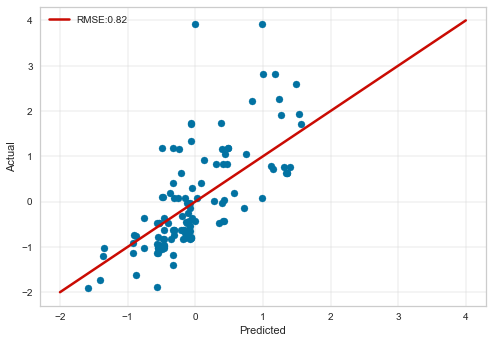

In [20]:
plt.scatter(pred,y_test)
plt.grid(lw=0.4)
plt.plot(np.linspace(-2,4,100),np.linspace(-2,4,100),c="r",lw=2.5,label=f"RMSE:{round(np.sqrt(mean_squared_error(pred,y_test)),2)}")
plt.legend(loc=2)
plt.ylabel("Actual")
plt.xlabel("Predicted")

Poskusimo uporabiti še druge modele, da na koncu lahko primerjamo uspešnost. Za cilj imamo doseči čim večjo natančnost.

In [8]:
for train_index, test_index in ss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
model = lgb.LGBMRegressor().fit(X_train,y_train)
pred = model.predict(X_test)

Text(0.5, 0, 'Predicted')

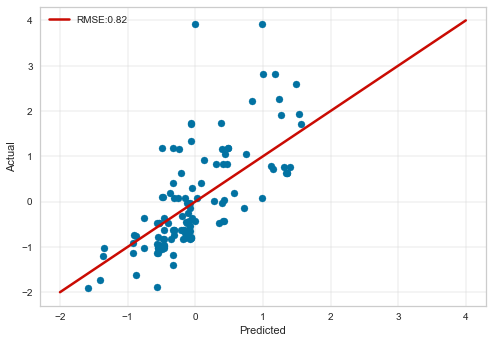

In [21]:

plt.scatter(pred,y_test)
plt.grid(lw=0.4)
plt.plot(np.linspace(-2,4,100),np.linspace(-2,4,100),c="r",lw=2.5,label=f"RMSE:{round(np.sqrt(mean_squared_error(pred,y_test)),2)}")
plt.legend(loc=2)
plt.ylabel("Actual")
plt.xlabel("Predicted")

In [24]:
model = MLPRegressor(random_state=0, max_iter=500)

for train_index, test_index in ss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
model.fit(X_train, y_train)
pred = model.predict(X_test)


Text(0.5, 0, 'Predicted')

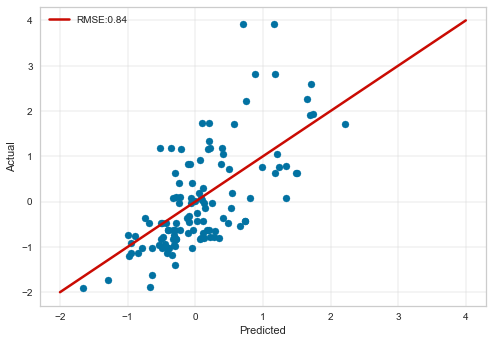

In [25]:
plt.scatter(pred,y_test)
plt.grid(lw=0.4)
plt.plot(np.linspace(-2,4,100),np.linspace(-2,4,100),c="r",lw=2.5,label=f"RMSE:{round(np.sqrt(mean_squared_error(pred,y_test)),2)}")
plt.legend(loc=2)
plt.ylabel("Actual")
plt.xlabel("Predicted")